1. batch_norm_gradient_check.py

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend

In [2]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                              use_batchnorm=True)

In [3]:
x_batch = x_train[:20]
t_batch = t_train[:20]

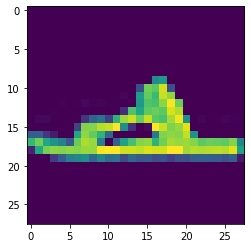

In [4]:
import matplotlib.pyplot as plt
import random
plt.imshow(x_train[random.randint(0, x_train.shape[0])].reshape(28, 28))

In [5]:
grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)

In [6]:
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:4.438093132258015e-08
b1:5.551212687768779e-13
gamma1:5.939431960241175e-08
beta1:5.0175680446030645e-08
W2:3.712943430298193e-08
b2:4.441375571354392e-14
gamma2:6.530181169257364e-08
beta2:5.799486519053902e-08
W3:1.2007167170659869e-07
b3:1.8820028486483258e-07


2. batch_norm_test.py

In [7]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

In [9]:
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

============== 1/16 ==============
epoch:0 | 0.104 - 0.118
epoch:1 | 0.115 - 0.106
epoch:2 | 0.115 - 0.104
epoch:3 | 0.115 - 0.132
epoch:4 | 0.115 - 0.162
epoch:5 | 0.115 - 0.192
epoch:6 | 0.115 - 0.221
epoch:7 | 0.115 - 0.253
epoch:8 | 0.115 - 0.269
epoch:9 | 0.115 - 0.293
epoch:10 | 0.115 - 0.313
epoch:11 | 0.115 - 0.333
epoch:12 | 0.115 - 0.344
epoch:13 | 0.115 - 0.377
epoch:14 | 0.115 - 0.403
epoch:15 | 0.115 - 0.419
epoch:16 | 0.115 - 0.434
epoch:17 | 0.115 - 0.449
epoch:18 | 0.115 - 0.463
No handles with labels found to put in legend.
epoch:19 | 0.115 - 0.476
============== 2/16 ==============
epoch:0 | 0.107 - 0.099
..\common\functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
epoch:1 | 0.107 - 0.083
epoch:2 | 0.107 - 0.119
epoch:3 | 0.107 - 0.16
epoch:4 | 0.107 - 0.2
epoch:5 | 0.107 - 0.245
epoch:6 | 0.107 - 0.273
epoch:7 | 0.107 - 0.303
epoch:8 | 0.107 - 0.346
epoch:9 | 0.107 - 0.359
epoch:10 | 0.107 - 0.389
epoch:11 | 0.107 - 0.4

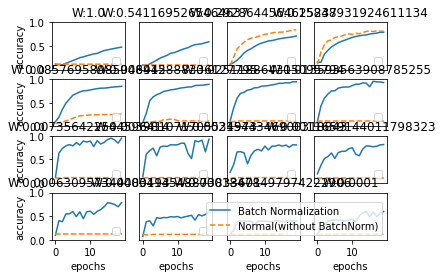

In [10]:
# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


3. hyperparameter_optimization.py

In [11]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

In [12]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [13]:
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

In [14]:
# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

val acc:0.6 | lr:0.009061252235354922, weight decay:3.6255908935132165e-07
val acc:0.15 | lr:1.0982213979504745e-05, weight decay:2.8919931592590605e-05
val acc:0.63 | lr:0.006354261196557903, weight decay:5.131973490193144e-06
val acc:0.07 | lr:1.602114100226551e-06, weight decay:8.501824746437624e-07
val acc:0.09 | lr:3.947582029905111e-05, weight decay:3.86357857467032e-06
val acc:0.05 | lr:7.138343173232895e-06, weight decay:1.5343146800994573e-06
val acc:0.07 | lr:3.6134057939381926e-05, weight decay:3.5349104861530186e-06
val acc:0.3 | lr:0.0009968706801167105, weight decay:6.790447264518182e-08
val acc:0.08 | lr:1.441412544269294e-06, weight decay:9.56092433441451e-07
val acc:0.17 | lr:0.00011320455015186683, weight decay:8.253123807753402e-05
val acc:0.13 | lr:1.7104893939977985e-05, weight decay:1.7727226392570433e-05
val acc:0.12 | lr:2.0621418933851894e-05, weight decay:8.825433234809929e-06
val acc:0.1 | lr:1.570414257085358e-05, weight decay:1.7237420582791595e-08
val acc:

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.67) | lr:0.009606848696232767, weight decay:1.032695392866899e-06
Best-2(val acc:0.65) | lr:0.005938482197573424, weight decay:8.470716379423212e-08
Best-3(val acc:0.64) | lr:0.007667418273010336, weight decay:2.8541577504605027e-07
Best-4(val acc:0.63) | lr:0.006354261196557903, weight decay:5.131973490193144e-06
Best-5(val acc:0.61) | lr:0.008097996115279033, weight decay:6.416783402397225e-05
Best-6(val acc:0.61) | lr:0.007967203794665997, weight decay:1.5433922920823008e-06
Best-7(val acc:0.6) | lr:0.009061252235354922, weight decay:3.6255908935132165e-07
Best-8(val acc:0.6) | lr:0.004012454056451765, weight decay:5.337907335421351e-08
Best-9(val acc:0.6) | lr:0.005378613889047238, weight decay:1.54770811696679e-08
Best-10(val acc:0.58) | lr:0.007952044639881953, weight decay:3.363143736105954e-08
Best-11(val acc:0.58) | lr:0.006538099664570144, weight decay:1.0895713201353638e-05
Best-12(val acc:0.57) | l

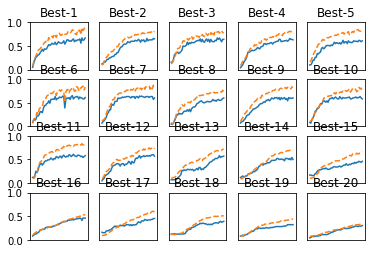

In [15]:
# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

4. optimizer_compare_mnist.py - check

In [16]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

In [17]:
# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

In [18]:
# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []  

In [19]:
# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


===========iteration:0===========
SGD:2.2892155364041775
Momentum:2.4188468848605575
AdaGrad:2.775111989720477
Adam:2.155536455449825
===========iteration:100===========
SGD:0.8758565888492222
Momentum:0.5376043363452381
AdaGrad:0.36879279099314266
Adam:0.43680896515441087
===========iteration:200===========
SGD:0.6834069150425481
Momentum:0.5056153227159423
AdaGrad:0.4175397499843991
Adam:0.4284484222411884
===========iteration:300===========
SGD:0.5689232619869928
Momentum:0.4150485299149239
AdaGrad:0.38655201433803166
Adam:0.40216671887293265
===========iteration:400===========
SGD:0.5753459772862383
Momentum:0.4577898089919865
AdaGrad:0.3516236256775818
Adam:0.3706122216212115
===========iteration:500===========
SGD:0.49046986700416517
Momentum:0.37616096536695287
AdaGrad:0.3322007473199351
Adam:0.3095461845568374
===========iteration:600===========
SGD:0.5685198527214514
Momentum:0.3866356115953653
AdaGrad:0.3277575842506446
Adam:0.3559906397810233
===========iteration:700========

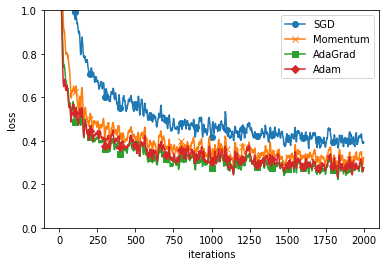

In [20]:
# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

5. optimizer_compare_naive.py - chec

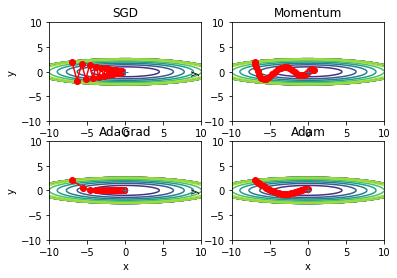

In [21]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)#
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()


overfit_dropout.py

In [ ]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


6. overfit_weight_decay.py

epoch:0, train acc:0.21666666666666667, test acc:0.1971
epoch:1, train acc:0.2966666666666667, test acc:0.2691
epoch:2, train acc:0.35333333333333333, test acc:0.3297
epoch:3, train acc:0.3933333333333333, test acc:0.3495
epoch:4, train acc:0.42, test acc:0.3715
epoch:5, train acc:0.4266666666666667, test acc:0.385
epoch:6, train acc:0.44666666666666666, test acc:0.3981
epoch:7, train acc:0.4633333333333333, test acc:0.4155
epoch:8, train acc:0.47, test acc:0.4155
epoch:9, train acc:0.53, test acc:0.4628
epoch:10, train acc:0.5166666666666667, test acc:0.4546
epoch:11, train acc:0.5433333333333333, test acc:0.4958
epoch:12, train acc:0.5766666666666667, test acc:0.5042
epoch:13, train acc:0.6233333333333333, test acc:0.5417
epoch:14, train acc:0.6133333333333333, test acc:0.5498
epoch:15, train acc:0.6666666666666666, test acc:0.5703
epoch:16, train acc:0.6666666666666666, test acc:0.5547
epoch:17, train acc:0.67, test acc:0.5792
epoch:18, train acc:0.6666666666666666, test acc:0.5618


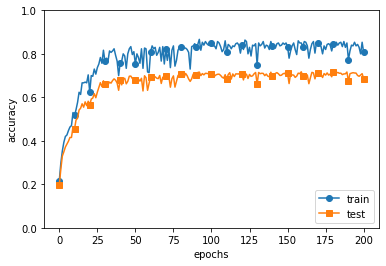

In [22]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


7. weight_init_activation_histogram.py

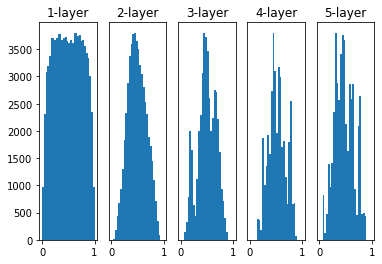

In [27]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


8. weight_init_compare.py

===========iteration:0===========
std=0.01:2.302518796399169
Xavier:2.2966085344985445
He:2.371977953685595
===========iteration:100===========
std=0.01:2.302335831745621
Xavier:2.120394025123602
He:1.101696008438251
===========iteration:200===========
std=0.01:2.302312833973903
Xavier:1.6529115667844412
He:0.7534382448641568
===========iteration:300===========
std=0.01:2.3025135495988307
Xavier:1.1142314756351932
He:0.6295910157102869
===========iteration:400===========
std=0.01:2.3021256595787545
Xavier:0.9282907407202453
He:0.5711774612176777
===========iteration:500===========
std=0.01:2.3018116842620975
Xavier:0.7843531366843923
He:0.4929028866425959
===========iteration:600===========
std=0.01:2.302655785492789
Xavier:0.7799260028858698
He:0.6062213406735824
===========iteration:700===========
std=0.01:2.3018799806744976
Xavier:0.691128658112385
He:0.45783915941170683
===========iteration:800===========
std=0.01:2.3029155133278802
Xavier:0.6526881922895351
He:0.4764082914721626
=

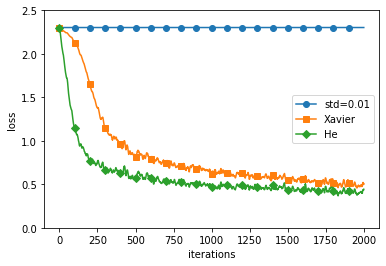

In [24]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()
